# Get dataset

In [65]:
import os
import glob
import string
import unicodedata


In [66]:


all_letters = string.ascii_letters + ".;,'"
n_letters = len(all_letters)

def findFiles(path) -> list:
    return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
    
def extract_from_file(path):
    f = open(path, 'r', encoding='utf-8')
    names = f.read().strip().split('\n')
    return names


In [67]:
category_lines = {}
all_categories = []

file_pathes = findFiles('data/names/*.txt')
for path in file_pathes:
    category = os.path.splitext(os.path.basename(path))[0]
    all_categories.append(category)
    lines = extract_from_file(path)
    category_lines[category] = lines
n_categories = len(all_categories)



In [68]:
all_categories

['Polish',
 'Spanish',
 'English',
 'Irish',
 'German',
 'Chinese',
 'Greek',
 'Italian',
 'Vietnamese',
 'Czech',
 'Korean',
 'French',
 'Dutch',
 'Arabic',
 'Scottish',
 'Portuguese',
 'Japanese',
 'Russian']

In [69]:
for key, value in category_lines.items():
    print(f'{key}: {len(value)}')

Polish: 139
Spanish: 298
English: 3668
Irish: 232
German: 724
Chinese: 268
Greek: 203
Italian: 709
Vietnamese: 73
Czech: 519
Korean: 94
French: 277
Dutch: 297
Arabic: 2000
Scottish: 100
Portuguese: 74
Japanese: 991
Russian: 9408


# Turning Names into Tensors

In [70]:
import torch

timesteps = 1

def letterToIndex(letter) -> int:
    return all_letters.find(letter)

# output: <1 x n_letters>
def letterToTensor(letter) -> torch.Tensor:
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# output: <line length x 1 x n_letters> <=> (timesteps, batch size, feature size)
def lineToTensor(line) -> torch.Tensor:
    tensor = torch.zeros(len(line), timesteps, n_letters)
    for idx, letter in enumerate(line):
        tensor[idx][0][letterToIndex(letter)] = 1
    return tensor



In [71]:

tensor_line = lineToTensor('letter')

In [72]:
print(tensor_line.shape)
tensor_line

torch.Size([6, 1, 56])


tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0

In [73]:
import torch.nn as nn
from model import RNNFromScratch, RNNUsingModule

n_hidden = 128

rnn = RNNFromScratch(input_size=n_letters, hidden_size=n_hidden, output_size=n_categories)

In [74]:
input_line = lineToTensor('Aiden')
hidden = torch.zeros(1, n_hidden)
# 만약 맡에 코드처럼 input_line[0] 이렇게 안 하고 즉 batch size=1로 하지 않고 batch size=line length로 하면 hidden은 어떻게 update?
# hidden states가 여러개 생성되며 tensor로 관리된다.
y_hat, next_line_hidden = rnn(input_line, hidden)

In [75]:
y_hat

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
       grad_fn=<LogSoftmaxBackward0>)

In [76]:
def categoryFromOutput(output):
    top_v, top_i = output.topk(1)
    category_i = top_i.item()
    category = all_categories[category_i]
    return category, category_i

In [77]:
import random

def randomChoice(list):
    return list[random.randint(0, len(list)-1)]

def getTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [78]:
for _ in range(10):
    category, line, category_tensor, line_tensor = getTrainingExample()
    print(f"Category: {category} / Line: {line} / category tensor: {category_tensor}")

Category: Greek / Line: Close / category tensor: tensor([6])
Category: Czech / Line: Brabbery / category tensor: tensor([9])
Category: Vietnamese / Line: Ha / category tensor: tensor([8])
Category: Irish / Line: Reilly / category tensor: tensor([3])
Category: Japanese / Line: Saji / category tensor: tensor([16])
Category: Czech / Line: Karlovsky / category tensor: tensor([9])
Category: Russian / Line: Dats / category tensor: tensor([17])
Category: Spanish / Line: Arechavaleta / category tensor: tensor([1])
Category: Portuguese / Line: Fernandes / category tensor: tensor([15])
Category: Vietnamese / Line: Chung / category tensor: tensor([8])


In [79]:
lr = 0.001
model = RNNFromScratch(input_size=n_letters, hidden_size=n_hidden, output_size=n_categories)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

def train(line_tensor, category_tensor):
    hidden = model.initHidden()
    model.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()

    for p in model.parameters():
        p.data.add_(p.grad.data, alpha=-lr)
    
    return output, loss.item() # number

In [80]:
lr = 0.001
model = RNNUsingModule(input_size=n_letters, hidden_size=n_hidden, output_size=n_categories)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

def train(line_tensor, category_tensor):
    
    hidden = model.initHidden()
    model.zero_grad()

    output = model(line_tensor, hidden)
    
    
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    return output, loss.item() # number

# Test batch size / sequence length / feature size

In [81]:
category, line, category_tensor, line_tensor = getTrainingExample()


In [82]:
input = line_tensor.transpose(0, 1)
rnn = nn.RNN(input_size=n_letters, hidden_size=n_hidden, batch_first=True)
fc = nn.Linear(n_hidden, n_categories)
bias = nn.Parameter(torch.ones([n_categories]))
hidden = torch.zeros([1, 1, 128])
output, hidden_ = rnn(input, hidden)
output = output[:, -1, :]
output.shape
output2 = fc(output) + bias
output2.shape

torch.Size([1, 18])

In [83]:
# 
size = line_tensor.size()
input = line_tensor.transpose(0, 1)
rnn = RNNUsingModule(input_size=n_letters, hidden_size=n_hidden, output_size=n_categories)
hidden = rnn.initHidden()


In [84]:
output = rnn(input, hidden)
print(f'output: {output.size()}')
print(f"target: {category_tensor.size()}")


output: torch.Size([1, 18])
target: torch.Size([1])


# Training

In [85]:
import time
import math

epochs = 100000
every_print = 5000
every_plot = 1000

def timeSince(since) -> string:
    now = time.time()
    duration = now - since
    minute = math.floor(duration / 60)
    sec = duration - minute * 60

    return '{} : {}'.format(minute, math.floor(sec))


In [86]:
all_losses = []
current_loss = 0
start = time.time()

for epoch in range(epochs+1):
    category, line, category_tensor, line_tensor = getTrainingExample()
    line_tensor = line_tensor.transpose(0, 1)
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if epoch % every_print == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / epochs * 100, timeSince(start), loss, line, guess, correct))

    if epoch % every_plot == 0:
        all_losses.append(current_loss / every_plot)
        current_loss = 0


0 0% (0 : 0) 2.9266 Unkle / French ✗ (German)
5000 5% (0 : 8) 1.1250 Vincent / French ✓
10000 10% (0 : 17) 0.8533 Jamieson / Scottish ✓
15000 15% (0 : 25) 0.3184 Ponarovsky / Russian ✓
20000 20% (0 : 33) 3.4439 Amador / French ✗ (Spanish)
25000 25% (0 : 42) 1.9924 Silverstein / Scottish ✗ (German)
30000 30% (0 : 50) 1.2256 Ballaltick / Czech ✓
35000 35% (0 : 58) 1.1496 Valencia / Spanish ✓
40000 40% (1 : 6) 0.1954 O'Hannagain / Irish ✓
45000 45% (1 : 14) 0.4978 Law / Chinese ✓
50000 50% (1 : 23) 0.9706 Chong / Korean ✓
55000 55% (1 : 31) 1.2587 Handal / Arabic ✓
60000 60% (1 : 40) 0.5402 Lai / Chinese ✓
65000 65% (1 : 48) 0.8279 Fabbri / Italian ✓
70000 70% (1 : 57) 2.7380 Close / Scottish ✗ (Greek)
75000 75% (2 : 5) 3.0315 Kerr / Dutch ✗ (Scottish)
80000 80% (2 : 13) 0.8160 Archambault / French ✓
85000 85% (2 : 22) 1.9125 Otake / Russian ✗ (Japanese)
90000 90% (2 : 30) 0.3408 Son / Korean ✓
95000 95% (2 : 39) 0.1453 Okubo / Japanese ✓
100000 100% (2 : 49) 1.4079 Koumans / Dutch ✓


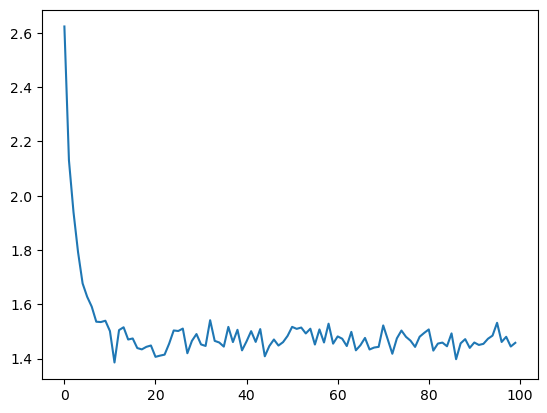

In [87]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses[1:])

/tmp/ipykernel_5014/1895847313.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_5014/1895847313.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


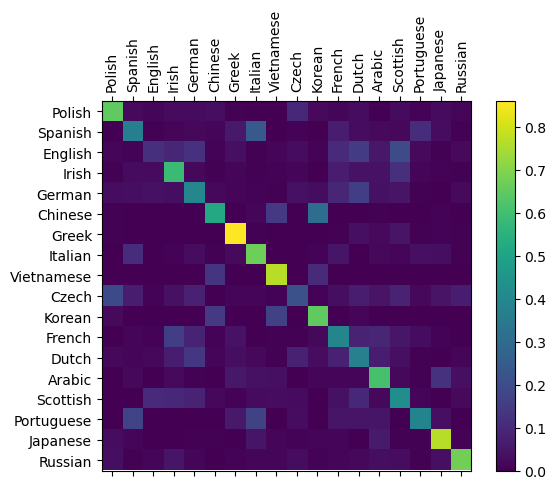

In [88]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = model.initHidden()
    input = line_tensor.transpose(0, 1)
    # for i in range(line_tensor.size()[0]):
    #     output, hidden = rnn(line_tensor[i], hidden)
    output = model(input, hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = getTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [91]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Hodolski')
predict('Podolski')


> Dovesky
(4.95) Russian
(3.82) Irish
(3.52) Scottish

> Jackson
(4.17) Scottish
(3.41) Russian
(3.28) English

> Satoshi
(3.79) Japanese
(3.47) Polish
(3.27) Italian

> Hodolski
(6.60) Polish
(3.94) Czech
(3.89) Japanese

> Podolski
(6.09) Polish
(3.64) Russian
(3.58) Czech
